# Supervised Sector Classification

Let's now use the features we constructed and the known sectors to build a supervised classification model. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import gensim
import enum

In [74]:
agreements_features = pd.read_pickle("classification_features.pkl")

In [76]:
def make_np_vector(x):
    out = np.zeros(len(x))
    for i in range(len(x)):
        out[i] = x[i][1]
    return out

In [77]:
agreements_features.project_description_lsi = agreements_features.project_description_lsi.apply(make_np_vector)

In [78]:
agreements_features.project_name_lsi.apply(len)

0       200
1       200
2       200
3       200
4       200
       ... 
3190    200
3191    200
3192    200
3193    200
3194    200
Name: project_name_lsi, Length: 3189, dtype: int64

In [79]:
agreements_features.project_name_lsi = agreements_features.project_name_lsi.apply(make_np_vector)

For now, let's just build a model only on the completely labeled data.

In [80]:
labeled_set = agreements_features.dropna(how='any',inplace=False,subset=['project_desc','Project Name','sector_id'])

Let's start by just using the already calculated LSI vectors as our input features. Maybe also the year?

In [170]:
desc_features = np.stack(labeled_set.project_description_lsi.to_numpy())
name_features = np.stack(labeled_set.project_name_lsi.to_numpy())
X_features = np.concatenate([labeled_set.year.to_numpy().reshape((-1,1)),desc_features,name_features],axis=1)
y = labeled_set['sector_id'].apply(int)

In [171]:
from sklearn.model_selection import train_test_split
X_test, X_train, y_test, y_train = train_test_split(X_features,y,train_size=0.4,stratify=y)


A random forest seems like a good place to start.

In [172]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_estimators=200)
clf.fit(X_train,y_train.to_numpy().ravel())

RandomForestClassifier(n_estimators=200)

In [173]:
y_train_pred = clf.predict(X_train)

In [174]:
correct = y_train_pred == y_train.to_numpy().ravel()
sum(correct) / len(correct)

1.0

In [175]:
y_test_pred = clf.predict(X_test)
correct = y_test_pred == y_test.to_numpy().ravel()
sum(correct) / len(correct)

0.6397058823529411

Ok, 67% accuracy isn't too bad here, I guess.

In [176]:
from sklearn.metrics import plot_confusion_matrix

In [1]:
with open("world_bank_sectors.txt") as f:
  sectors = f.read()

sectors_list = sectors.split("\n")

sector_dict = dict()
current_major_sector = ''
for sector in sectors_list:
    if sector == '':
        current_major_sector = ''
        continue
    if current_major_sector == '':
        current_major_sector = sector
        sector_dict[current_major_sector] = []
        continue
    if current_major_sector in sector_dict.keys():
        sector_dict[current_major_sector].append(sector)
sectors = list(sector_dict.keys())

<Figure size 720x720 with 0 Axes>

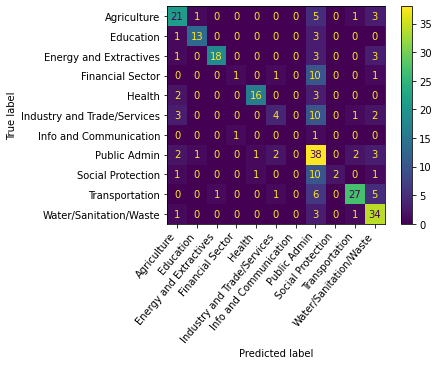

In [191]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(clf,X_test,y_test.to_numpy().ravel(),display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

Some classes do pretty well. It seems like Public Admin is the sector that everything gets confused for. It's also the largest (and maybe vaguest) category, so that's not too surprising. 